# 고객 대출등급 분류 해커톤 - EDA

- 알고리즘 | 정형 | 분류 | 금융 | Macro F1 Score
- 경진대회 링크 : https://dacon.io/competitions/official/236214/codeshare
- [주제] 고객의 대출등급을 예측하는 AI 알고리즘 개발
- [설명] 대출 고객과 관련된 데이터 분석을 통해 고객의 대출등급 예측하는 AI 모델을 개발해야 합니다.


In [1]:
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

import re
import json

pd.set_option('display.max_columns', None)

from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## 1. 데이터 불러오기 및 확인

In [3]:
D = pd.read_csv('data/train.csv')
D.head(3)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A


In [4]:
# 변수 타입 확인
set(D.dtypes.values)

{dtype('int64'), dtype('float64'), dtype('O')}

In [5]:
# 수치형 변수 통계량 확인
num_cols = D.select_dtypes(['int', 'float']).columns.tolist()
D.select_dtypes(['int', 'float']).describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [6]:
# 문자(object) 변수 확인
obj_cols = D.select_dtypes('object').columns[1:-1] # ID, 대출등급 제외
D.select_dtypes('object').head()

,ID,대출기간,근로기간,주택소유상태,대출목적,대출등급
0,TRAIN_00000,36 months,6 years,RENT,부채 통합,C
1,TRAIN_00001,60 months,10+ years,MORTGAGE,주택 개선,B
2,TRAIN_00002,36 months,5 years,MORTGAGE,부채 통합,A
3,TRAIN_00003,36 months,8 years,MORTGAGE,부채 통합,C
4,TRAIN_00004,60 months,Unknown,RENT,주요 구매,B


## 2. 문자형 변수 시각화 및 전처리

### 1) 대출기간

In [7]:
D['대출기간'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [8]:
preprocess_loans_period = lambda x: 0 if x == ' 36 months' else 1

In [9]:
D['대출기간'] = D['대출기간'].apply(preprocess_loans_period)

### 2) 근로기간

In [10]:
D['근로기간'].unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [11]:
def preprocess_work_period(raw:str):
    period = re.sub("[^0-9,+,<]", "", raw.replace(' ',''))
    if period == '':
        return 6 #근로기간의 평균 근사치
    elif (period == '10+'):
        return 10
    elif period == '<1':
        return 0
    else:
        return int(period)

In [12]:
D['근로기간'] = D['근로기간'].apply(preprocess_work_period)

In [13]:
D['근로기간'].unique()

array([ 6, 10,  5,  8,  9,  2,  1,  3,  7,  4,  0])

- 대출등급 별 근로기간 시각화

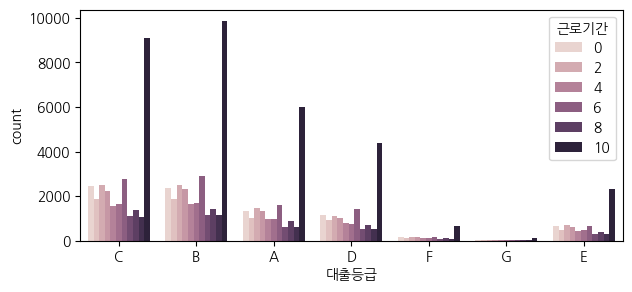

In [14]:
plt.figure(figsize=(7, 3))
sns.countplot(data=D, x='대출등급', hue='근로기간')
plt.show()

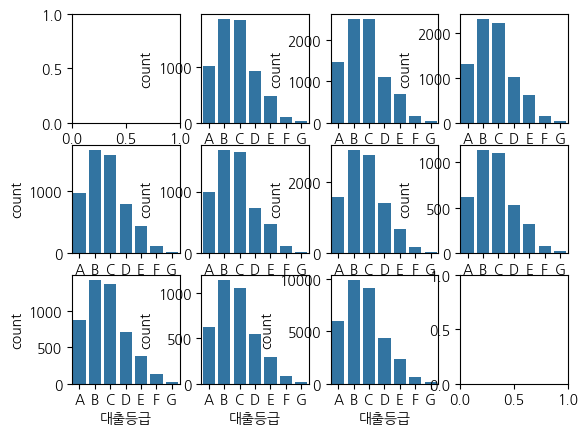

In [15]:
# 근로기간 분포 보기
fig, ax = plt.subplots(3, 4)

for i in range(0, 3):
    for j in range(0, 4):
        # print(i, j)
        if (i == 0) and (j == 0):
            sns.countplot(data=D[D['근로기간'].isnull()], x=D[D['근로기간'].isnull()]['대출등급'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ax=ax[i][j])
        else:
            sns.countplot(data=D[D['근로기간']==i*4+j], x=D[D['근로기간']==i*4+j]['대출등급'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G'], ax=ax[i][j])

### 3) 주택소유상태 

- 대출등급 별 주택소유상태 시각화 

In [16]:
D['주택소유상태'].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object)

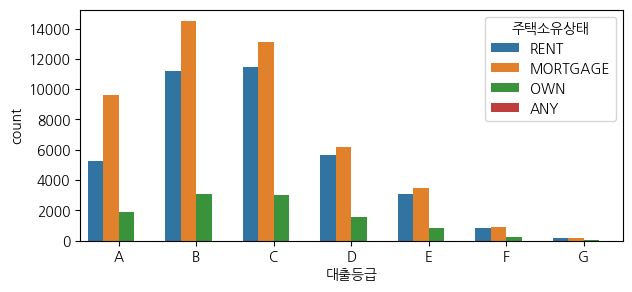

In [17]:
plt.figure(figsize=(7, 3))
sns.countplot(data=D, x='대출등급', hue='주택소유상태', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.show()

### 4) 대출목적

- 대출등급 별 대출목적 시각화

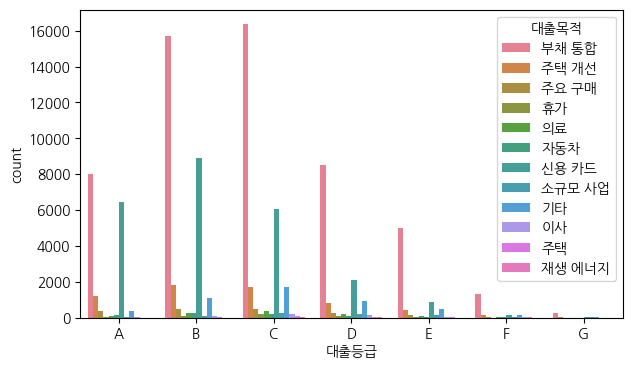

In [18]:
plt.figure(figsize=(7, 4))
sns.countplot(data=D, x='대출등급', hue='대출목적', order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.show()

In [19]:
D['대출목적'].unique()

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)

In [20]:
# def preprocess_categorycal_cols(raw_rows:list, type_cols:list, col_name:str):
#     result_dict = {}
#     for uc in type_cols:
#         result_dict[f'{col_name}_{uc}'] = [1 if r==uc else 0 for r in raw_rows]
#     return result_dict

def preprocess_categorycal_cols(raw_df, category_cols, train=True):
    df = raw_df.copy()

    if train:
        label_dict = {}
        for col in category_cols:
            df[col]= encoder.fit_transform(df[col])
            label_dict[col] = encoder.classes_.tolist()
        
        with open('data/label.json', 'w') as f:
            json.dump(label_dict, f)

    else:
        with open('data/label.json', 'r') as f:
            label_dict = json.load(f)
        for col in category_cols:
            label_ls = label_dict[col]
            new_col = [label_ls.index(v) if v in label_ls else len(label_ls) for v in df[col]]
            df[col] = new_col

    return df
    

In [21]:
D = preprocess_categorycal_cols(D, ['주택소유상태', '대출목적'])

In [22]:
D.head(2)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,0,6,3,72000000,18.90,15,1,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,1,10,1,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0,B


## 3. 수치형 변수 시각화 및 전처리

### 파생변수 추가

- 상환 비율: 대출금액 대비 총상환원금

- 대출 금액 대비 소득 비율: 대출금액 대비 연간소득
- 소득 대비 대출 금액 비율: 연간소득 대비 대출금액 (소득보다 대출을 더 많이 빌린사람 ~ 소득에 비해 대출이 적은사람)

- 상환원금 대비 이자 비율: 이자를 얼마나 착실하게 갚았는가 확인

In [23]:
D['상환비율'] = D['총상환원금'] / D['대출금액']
D['이자비율'] = D['총상환이자'] / D['대출금액']
D['대출금액_대비_소득_비율'] = D['연간소득'] / D['대출금액']
D['소득_대비_대출금액_비율'] = D['대출금액'] / D['연간소득']
D['상환원금_대비_이자_비율'] = np.log10((D['총상환이자'] + 1) / (D['총상환원금'] + 1) + 1)

In [26]:
append_cols = ['상환비율', '이자비율', '대출금액_대비_소득_비율', '소득_대비_대출금액_비율', '상환원금_대비_이자_비율']
num_cols.extend(append_cols)

In [30]:
for nc in append_cols:
    D[nc] = D[nc].apply(lambda x: max(D[D[nc]!=x][nc]) if x == np.inf else x)

In [31]:
def plot_distribution(df, columns):
    plt.figure(figsize=(8, len(columns)*2))
    for i, col in enumerate(columns):
        plt.subplot(len(columns), 1, i+1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

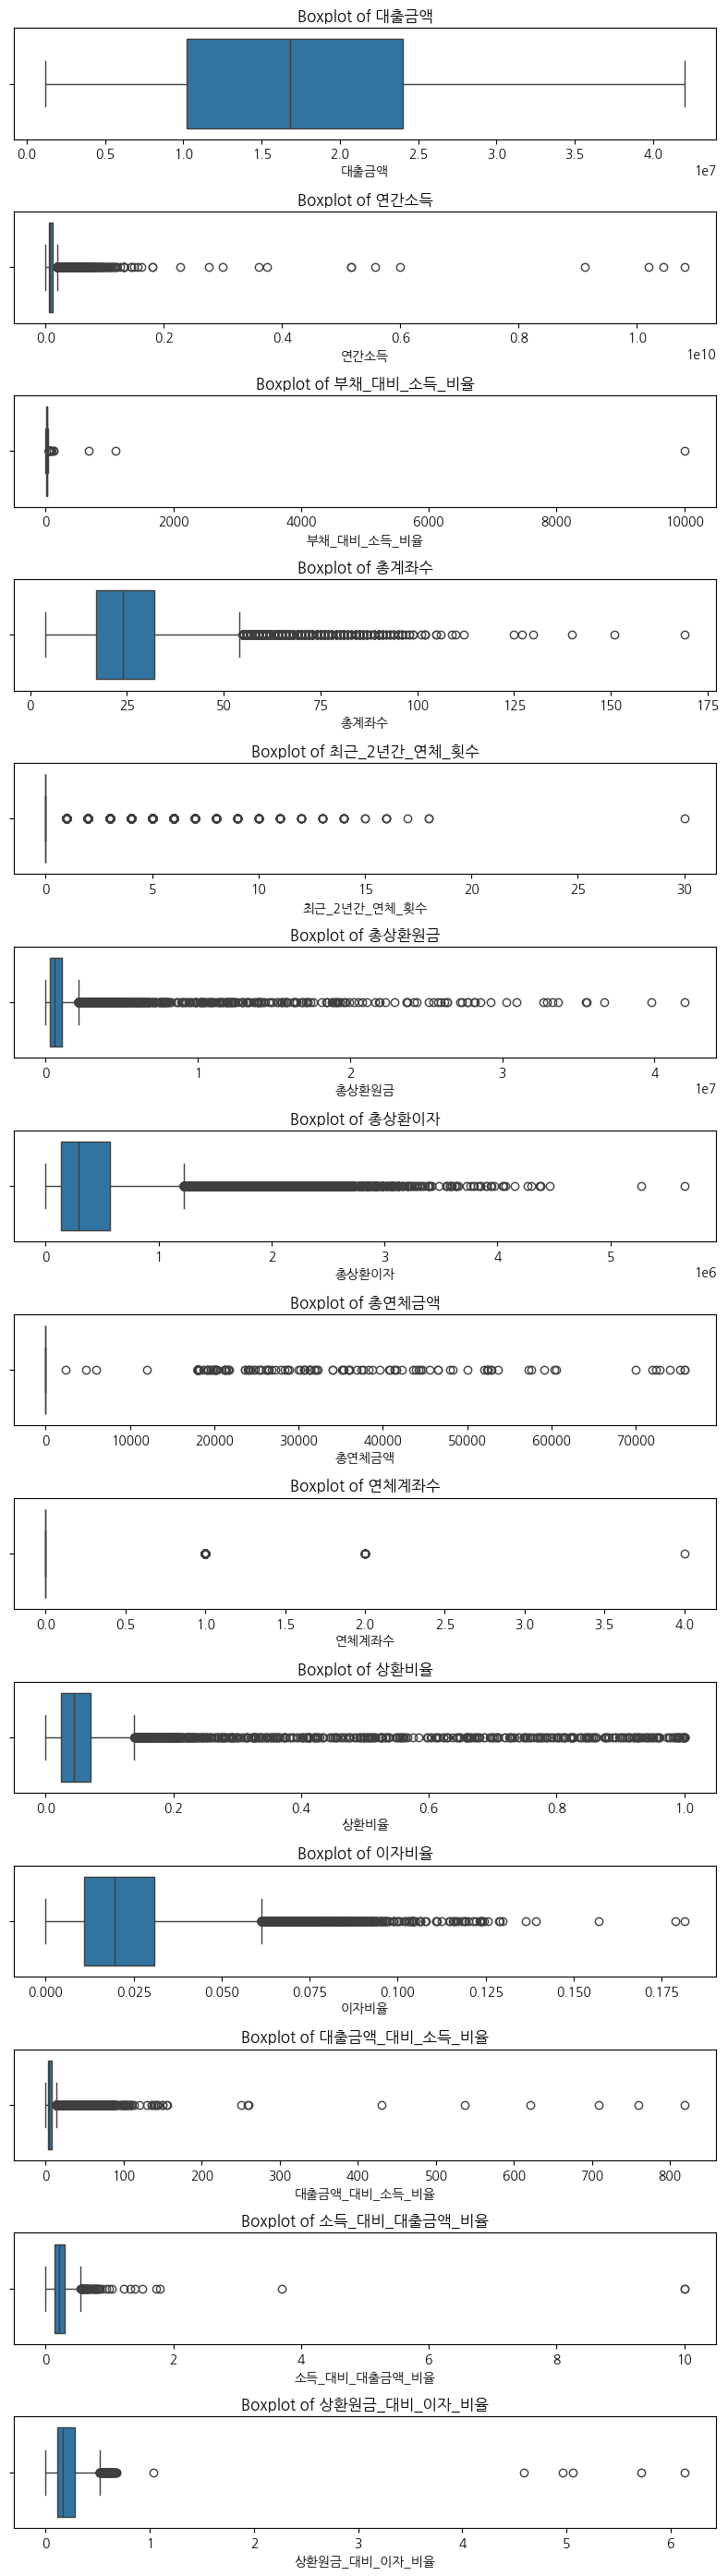

In [32]:
plot_distribution(D, num_cols)

In [33]:
scaling_cols = ['연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자',
                '상환비율', '대출금액_대비_소득_비율', '소득_대비_대출금액_비율', '상환원금_대비_이자_비율']

In [34]:
def scale_skewed_features(df, feature_list):
    df_transformed = df.copy()
    df_transformed[feature_list] = np.log10(df[feature_list] + 1)
    return df_transformed

In [35]:
DF = scale_skewed_features(D, scaling_cols)

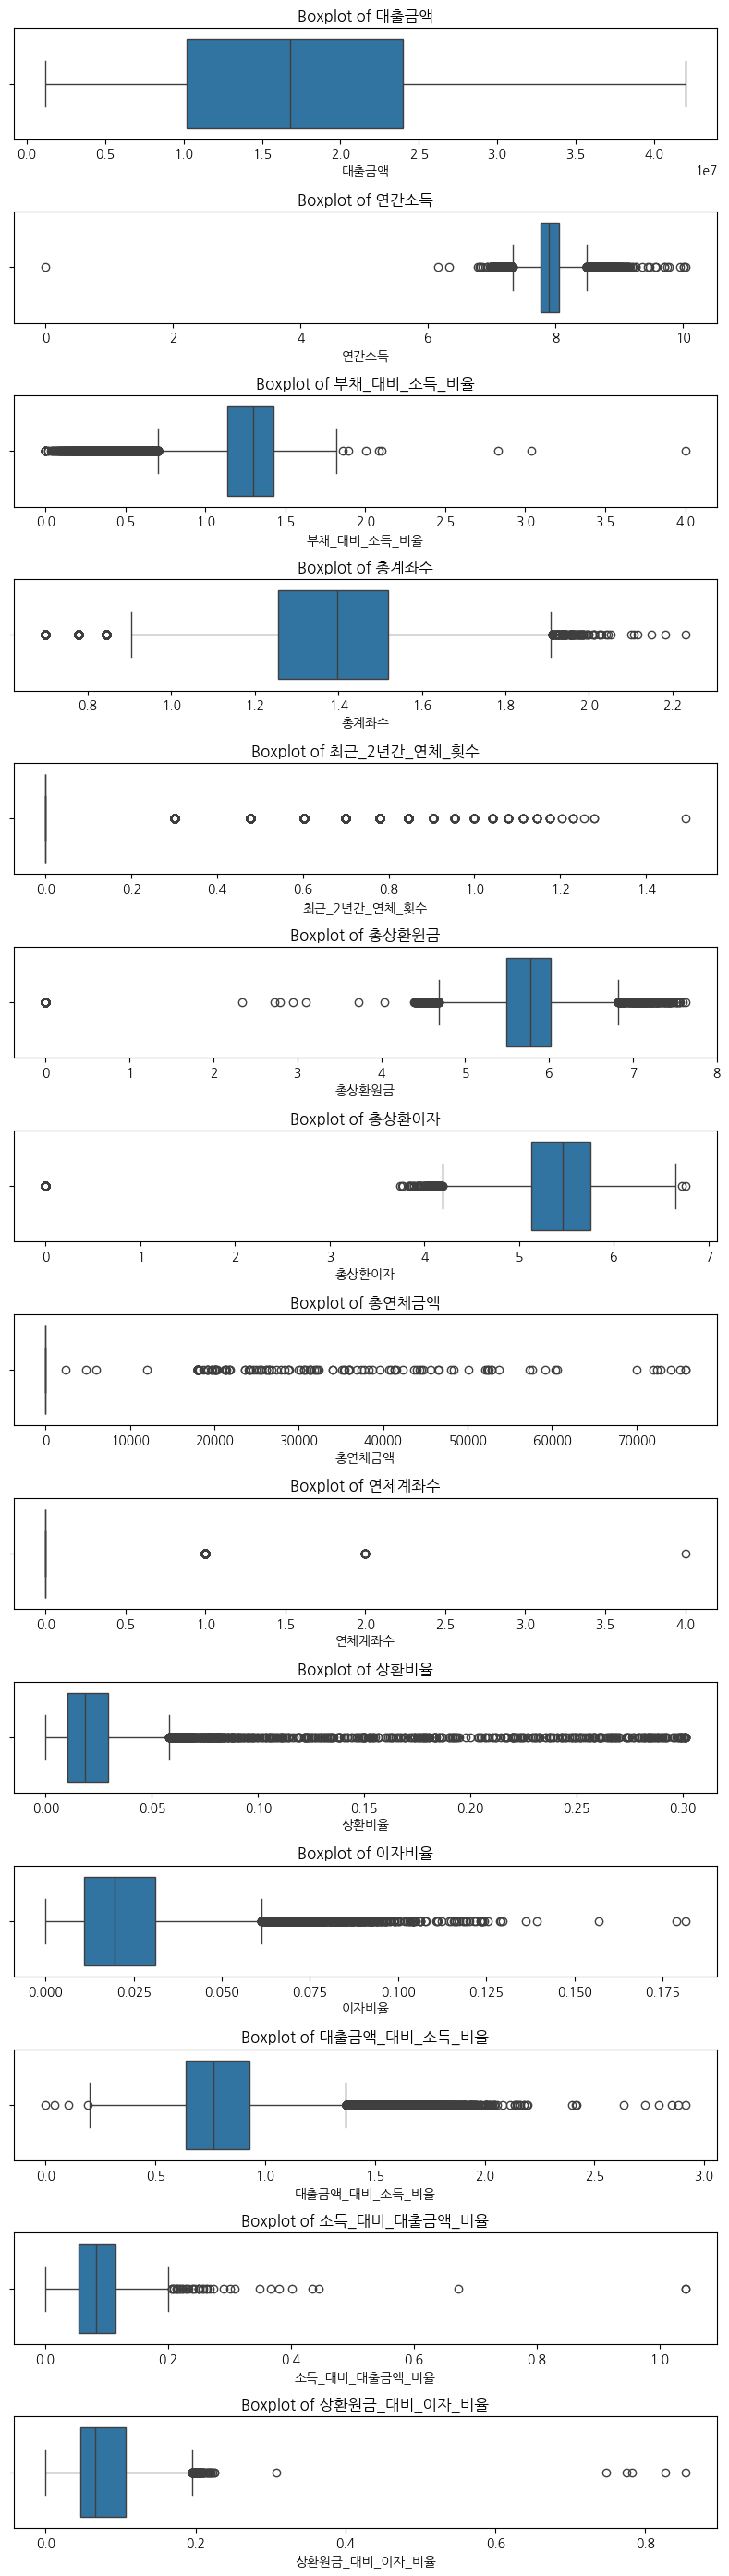

In [37]:
plot_distribution(DF, num_cols)

## 5. 특징들 간 상관관계 시각화

In [38]:
DF = DF.set_index('ID')

In [39]:
y = DF.pop('대출등급')

<Axes: >

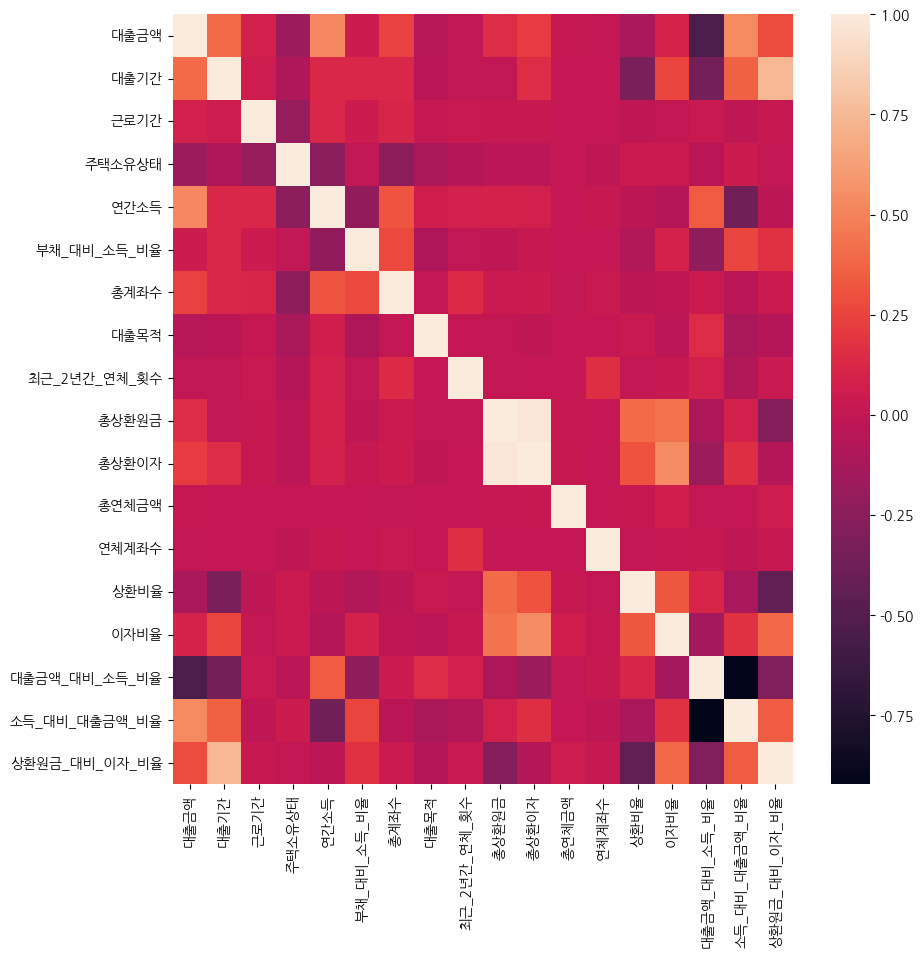

In [40]:
correlations = DF.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=False)

<Axes: xlabel='상환원금_대비_이자_비율', ylabel='대출등급'>

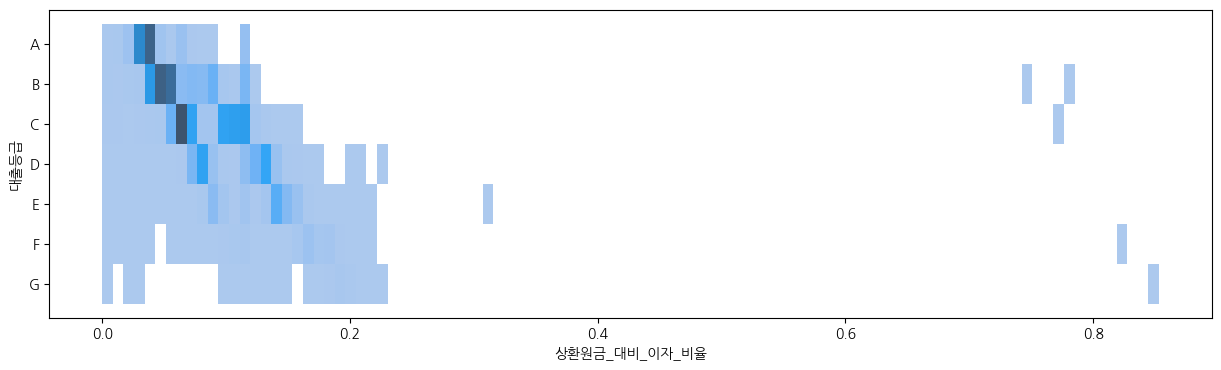

In [41]:
plt.figure(figsize=(15, 4))
temp = pd.concat([DF, y], axis=1)
temp = temp[temp['상환원금_대비_이자_비율'] < 1]
sns.histplot(data=temp.sort_values('대출등급'), x='상환원금_대비_이자_비율', y='대출등급', bins=[100, 3])

## 5. 전처리 함수 정의

In [45]:
def feature_engineering(D, train=True):
    D['대출기간'] = D['대출기간'].apply(preprocess_loans_period)
    D['근로기간'] = D['근로기간'].apply(preprocess_work_period)

    D = preprocess_categorycal_cols(D, ['주택소유상태', '대출목적'], train)

    D['상환비율'] = D['총상환원금'] / D['대출금액']
    D['이자비율'] = D['총상환이자'] / D['대출금액']
    D['대출금액_대비_소득_비율'] = D['연간소득'] / D['대출금액']
    D['소득_대비_대출금액_비율'] = D['대출금액'] / D['연간소득']
    D['상환원금_대비_이자_비율'] = np.log10((D['총상환이자'] + 1) / (D['총상환원금'] + 1) + 1)
    
    append_cols = ['상환비율', '이자비율', '대출금액_대비_소득_비율', '소득_대비_대출금액_비율', '상환원금_대비_이자_비율']

    DF = scale_skewed_features(D, scaling_cols)
    for nc in append_cols:
        DF[nc] = DF[nc].apply(lambda x: max(DF[DF[nc]!=x][nc]) if x == np.inf else x)        
    return DF

In [55]:
raw_df = pd.read_csv('data/train.csv')
train_df = feature_engineering(raw_df)
train_df.to_csv('data/train_preprocessing.csv', index=False, index_label='ID')

In [54]:
raw_df = pd.read_csv('data/test.csv')
test_df = feature_engineering(raw_df, False)
test_df.to_csv('data/test_preprocessing.csv', index=False, index_label='ID')